# Exercici 1: YOLO

Fer servir YOLO per a detecció d'objectes en les imatges anteriors

Implementació: https://github.com/eriklindernoren/PyTorch-YOLOv3

Adaptar el codi de detecció per a que funcioni en Notebooks


In [1]:
from models import *
from utils.utils import *
from utils.datasets import *

import os
import sys
import time
import datetime

from PIL import Image
import cv2

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
#from matplotlib.ticker import NullLocator

In [2]:
## https://stackoverflow.com/a/53576407/844372

#def boundBox_restore(boundingbox, ori_size=(ori_image_width,ori_image_height), resized_size=(resized_image_size,resized_image_size)):
def boundBox_restore(boundingbox, original_size, resized_size):

    #h, w = ori_size
    h, w = original_size
    #sh, sw = resized_size
    sh, sw = resized_size

    scale_ratio =  w / sw

    ox,oy,ow,oh = boundingbox

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0


    # remove pad
    ox = ox - pad_left
    oy = oy - pad_top

    # rescale
    ox = ox * scale_ratio
    oy = oy * scale_ratio
    ow = ow * scale_ratio
    oh = oh * scale_ratio


    return (ox,oy,oh,ow)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_definition = "config/yolov3.cfg"
image_size = 416
batch_size = 1
confidence_threshold = 0.8
non_max_supression_threshold = 0.4

# Set up model
#model = Darknet(model_definition, img_size=image_size).to(device)
model = Darknet(model_definition).to(device)

# Load weights
model.load_darknet_weights("weights/yolov3.weights")

# Set evaluation model
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [4]:
dataloader = DataLoader(
    ImageFolder("Imatges"), #, img_size=image_size
    batch_size=batch_size,
    shuffle=False,
    num_workers=0)

# Extract class labels from file
classes = load_classes("data/coco.names")

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [5]:
# Detections 

imgs = []
img_detections = []

print("\nPerforming object detection:")
prev_time = time.time()

for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
    # Configure input
    input_imgs = Variable(input_imgs.type(Tensor))
    
    # Get detections
    with torch.no_grad():
        detections = model(input_imgs)
        detections = non_max_suppression(detections, confidence_threshold, non_max_supression_threshold)
        
    # Log progress
    current_time = time.time()
    inference_time = datetime.timedelta(seconds=current_time - prev_time)
    prev_time = current_time
    print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))
    
    # Save images and detections
    imgs.extend(img_paths)
    img_detections.extend(detections)


Performing object detection:
	+ Batch 0, Inference Time: 0:00:00.393556
	+ Batch 1, Inference Time: 0:00:00.328504
	+ Batch 2, Inference Time: 0:00:00.093588
	+ Batch 3, Inference Time: 0:00:00.036235


In [6]:
# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0,1,20)]


Saving images:
(0) Image: 'Imatges/car.jpg'
Current size: 416 - Original size: (2139, 3500)
	+ Label: car, Conf: 0.99776
	+ Label: car, Conf: 0.99778
	+ Label: car, Conf: 0.99585
	+ Label: car, Conf: 0.99087
	+ Label: car, Conf: 0.99384
	+ Label: car, Conf: 0.99567
	+ Label: car, Conf: 0.99169
	+ Label: car, Conf: 0.98944
	+ Label: car, Conf: 0.96821
	+ Label: car, Conf: 0.98165


<Figure size 432x288 with 0 Axes>

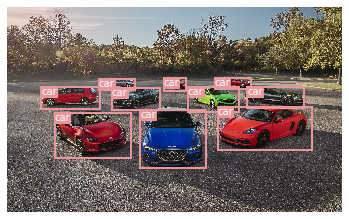

(1) Image: 'Imatges/girl_cars.jpg'
Current size: 416 - Original size: (3456, 5184)
	+ Label: car, Conf: 0.99990
	+ Label: person, Conf: 0.99991
	+ Label: person, Conf: 0.99996
	+ Label: car, Conf: 0.99709
	+ Label: person, Conf: 0.99995
	+ Label: backpack, Conf: 0.95384
	+ Label: car, Conf: 0.96573
	+ Label: car, Conf: 0.96501
	+ Label: person, Conf: 0.92046
	+ Label: person, Conf: 0.99975
	+ Label: car, Conf: 0.89824
	+ Label: handbag, Conf: 0.90861


<Figure size 432x288 with 0 Axes>

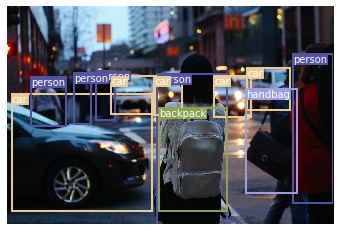

(2) Image: 'Imatges/people.jpg'
Current size: 416 - Original size: (1333, 2000)
	+ Label: person, Conf: 1.00000
	+ Label: person, Conf: 0.99998
	+ Label: person, Conf: 0.99996
	+ Label: person, Conf: 0.99995
	+ Label: person, Conf: 0.99997
	+ Label: person, Conf: 0.99996
	+ Label: person, Conf: 0.99999
	+ Label: person, Conf: 0.99996
	+ Label: person, Conf: 0.99989
	+ Label: person, Conf: 0.99962
	+ Label: person, Conf: 0.99729


<Figure size 432x288 with 0 Axes>

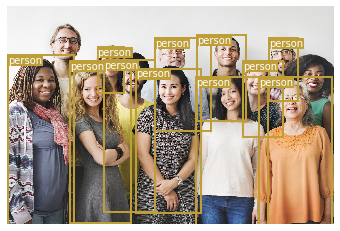

(3) Image: 'Imatges/traffic.jpg'
Current size: 416 - Original size: (640, 960)
	+ Label: car, Conf: 0.99938
	+ Label: car, Conf: 0.99814
	+ Label: car, Conf: 0.99227
	+ Label: car, Conf: 0.99891
	+ Label: car, Conf: 0.99793
	+ Label: car, Conf: 0.99645
	+ Label: car, Conf: 0.99689
	+ Label: car, Conf: 0.98894
	+ Label: car, Conf: 0.99920
	+ Label: car, Conf: 0.98165
	+ Label: car, Conf: 0.99553
	+ Label: car, Conf: 0.99909
	+ Label: car, Conf: 0.98897
	+ Label: car, Conf: 0.97925
	+ Label: car, Conf: 0.99733
	+ Label: car, Conf: 0.99000
	+ Label: truck, Conf: 0.92223
	+ Label: car, Conf: 0.97811
	+ Label: car, Conf: 0.98211
	+ Label: truck, Conf: 0.59303
	+ Label: car, Conf: 0.50930


<Figure size 432x288 with 0 Axes>

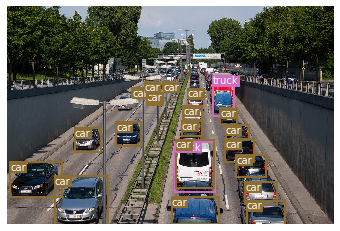

In [7]:
print("\nSaving images:")

# Iterate through images and save plot of detections
for img_i, (path, detections) in enumerate(zip(imgs, img_detections)):
    print("(%d) Image: '%s'" % (img_i, path))
    
    # Create plot
    img = np.array(Image.open(path))
    #plt.figure(figsize=img.shape[:2])
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    # Draw bounding boxes and labels of detections
    if detections is not None:
        #print(f"Colors: {bbox_colors}")
        # Rescale boxes to original image
        print(f"Current size: {image_size} - Original size: {img.shape[:2]}")
        #print(f"Before: {detections}")
        detections = rescale_boxes(detections, image_size, img.shape[:2])
        #print(f"After: {detections}")
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

        box_w = x2 - x1
        box_h = y2 - y1

        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]

        # Create a rectangle patch
        #ox,oy,oh,ow = boundBox_restore((x1, y1, box_w, box_h), img.shape[:2], (image_size, image_size))
        #print(f"bbox: {ox}, {oy}, {ow}, {oh}")
        #bbox = patches.Rectangle((ox, oy), ow, oh, linewidth=2, edgecolor=color, facecolor="none")
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")

        # Add the bbox to the plot
        ax.add_patch(bbox)
        #img.add_path(bbox)
        #cv2.rectangle(img, (ox, oy), (ox + ow, oy + oh), (255,0,0), 1)

        # Add label
        plt.text(x1, y1, s=classes[int(cls_pred)], color="white", verticalalignment="top", bbox={"color":color, "pad":0},)
        #cv2.putText(img, classes[int(cls_pred)], (x1, y1), cv2.FONT_HERSHEY_PLAIN, 1, (225,255,255), 1)

    # Save generated image with detections
    plt.axis("off")
    #filename = path.split("\\")[-1].split(".")[0]
    imagename = path.split(os.path.sep)[-1]
    filename = os.path.join("output", imagename) 
    
    plt.savefig(filename, bbox_inches="tight", pad_inches=0.0)
    plt.show()
    #cv2.imwrite(f"output\\{filename}.jpg",img)
    


# Exercici 2: Transfer learning amb YOLO [Opcional]
    
Entrenar un detector de ~~gats~~ una classe nova per el YOLO a partir de l'algoritme anterior


In [8]:
from models import *
from utils.utils import *
from utils.datasets import *
from utils.parse_config import *

import os
import sys
import time
import datetime

from PIL import Image
import cv2

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import warnings
#from test import evaluate

In [9]:
def evaluate(model, path, iou_thres, conf_thres, nms_thres, img_size, batch_size):
    model.eval()

    # Get dataloader
    dataset = ListDataset(path, img_size=img_size, augment=False, multiscale=False)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=dataset.collate_fn
    )

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    labels = []
    sample_metrics = []  # List of tuples (TP, confs, pred)
    for batch_i, (_, imgs, targets) in enumerate(tqdm.tqdm(dataloader, desc="Detecting objects")):

        # Extract labels
        labels += targets[:, 1].tolist()
        # Rescale target
        targets[:, 2:] = xywh2xyxy(targets[:, 2:])
        targets[:, 2:] *= img_size

        imgs = Variable(imgs.type(Tensor), requires_grad=False)

        with torch.no_grad():
            outputs = model(imgs)
            outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)

        sample_metrics += get_batch_statistics(outputs, targets, iou_threshold=iou_thres)

    # Concatenate sample statistics
    true_positives, pred_scores, pred_labels = [np.concatenate(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, labels)

    return precision, recall, AP, f1, ap_class

In [10]:
# Hyperparameters

batch_size = 4
num_epochs = 100
gradient_accumulations = 2
evaluation_interval = 1
img_size = 416
checkpoint_interval = 1

pretrained_weights = "weights/darknet53.conv.74"

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Get data configuration
data_config = parse_data_config("config/custom.data")
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = load_classes(data_config["names"])

print(f"Data config: {data_config}")
print(f"Train path: {train_path}")
print(f"Valid path: {valid_path}")
print(f"Classes: {class_names}")

Data config: {'gpus': '0,1,2,3', 'num_workers': '10', 'classes': '1', 'train': 'data/custom/train.txt', 'valid': 'data/custom/valid.txt', 'names': 'data/custom/classes.names'}
Train path: data/custom/train.txt
Valid path: data/custom/valid.txt
Classes: ['tree']


In [12]:
# Initiate model

model = Darknet("config/yolov3-custom.cfg").to(device)
model.apply(weights_init_normal)

# Load weights

model.load_darknet_weights(pretrained_weights)

In [13]:
# Get dataloader

dataset = ListDataset(train_path, augment=True, multiscale=True)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0,
    pin_memory = True,
    collate_fn = dataset.collate_fn
)

optimizer = torch.optim.Adam(model.parameters())

metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

In [14]:
# Train the model

#with warnings.catch_warnings():
#    warnings.simplefilter('error')
    
for epoch in range(num_epochs):
    model.train()

    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        batches_done = len(dataloader) * epoch + batch_i

        #imgs = Variable(imgs.to(device))
        #targets = Variable(targets.to(device))
        imgs = imgs.to(device)
        targets = targets.to(device)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % gradient_accumulations:
            # Accumulate gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        epoch_batches_left = len(dataloader) - (batch_i + 1)

        model.seen += imgs.size(0)


    if epoch % evaluation_interval == 0:
        print("\n---- Evaluating model ----")

        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            path = valid_path,
            iou_thres = 0.5,
            conf_thres = 0.5,
            nms_thres = 0.5,
            img_size = img_size,
            batch_size = batch_size
        )

        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean())
        ]

        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]

        print(ap_table)
        print(f"----- mAp {AP.mean()}")

    if epoch % checkpoint_interval == 0:
        torch.save(model.state_dict(), f"checkpoints/yolov3_ckpt_%d.pth" % epoch)
        

Detecting objects:   0%|          | 0/13 [00:00<?, ?it/s]


---- Evaluating model ----


Detecting objects: 100%|██████████| 13/13 [00:09<00:00,  2.03it/s]


ValueError: not enough values to unpack (expected 3, got 0)

In [ ]:
torch.cuda.empty_cache()